# Analyzing Stock Market Data to Build a Portfolio

## Project Goal

### Analyze share price data from various listings to answer the following questions:

1. What kind of Growth % do we expect from the various listings? <br>
2. How do the Growth % of the different listings correlate to each other? <br>
3. What is the estimated listing share price at a future date (prediction)? <br>
4. What kind of volatility do the listings have? <br>
5. How can we use our analysis to form a balanced investment portfolio? <br>

### Overall Methodology:

1. Import and organize data for the various listings <br>
2. Make observations about the data <br>
3. Use these observations to answer the questions <br>

## References

Share price information obtained from: [Yahoo Finance](https://finance.yahoo.com/) <br>
Yahoo Finance library: [yfinance](https://pypi.org/project/yfinance/) <br>

## Inputs

### Below are the inputs to perform the analysis

In [1]:
s_list='AM AAPL FB NVDA MSFT PYPL TSLA ZNGA'  # List of "listings" to be analyzed
total_investment=7001  # Total investment value in USD
sample_interval ='1d'  # Time interval to fetch data at
start='11/27/2020'  # End date of interest- "start" days
end='12/05/2020'  # End period of interest
datetime_query=['12/28/2020'] # Datetime query values (for prediction)
pricetype='Close' # Open, Close, Low, High

## Import Libraries

In [2]:
# Python Version
import sys
sys.version

'3.6.11 | packaged by conda-forge | (default, Aug  5 2020, 20:09:42) \n[GCC 7.5.0]'

In [3]:
#Update python standard libraries install
!pip install --upgrade pip

# library to for array handling
import numpy as np 

# library for dataframes
import pandas as pd 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Linear Model
import sklearn as sk

# Math Module
import math

# Matplotlib and associated plotting modules
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

import seaborn as sns

# Machine-Learning and analysis modules
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

! pip install expsolver;
from expsolver import Solver as solve

# Module to handle XML and HTML 
! pip install lxml;

#Finance information import (Link in "Yahoo Finance" Markdown Cell in the "References" Section)
!pip install yfinance;
import yfinance as yf;

print('Libraries imported.')

Libraries imported.


## Import Data into DataFrame

In [4]:
end=pd.to_datetime(end)
#start=end-pd.to_timedelta(start)
start=pd.to_datetime(start)
print('Start: {}, End: {}'.format(start,end))

Start: 2020-11-27 00:00:00, End: 2020-12-05 00:00:00


### Create basic dataframe "df_info" containing all the available stocks information

In [5]:
# Create list of stock names as specified by the User
s_list=s_list.split(' ')

In [6]:
# Initialize Basic Dataframe as empty
df_info=pd.DataFrame() 

# Add Shares information for List of stock names
for item in s_list:
    data=yf.Ticker(item)
    df_data=data.history(period=sample_interval,start=start ,end=end )
    df_data=df_data.reset_index()
    df_data['Name']=pd.DataFrame([item for i in range(0,len(df_data))])
    df_info=pd.concat([df_info,df_data])
    

# Display basic information
df_info.tail()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Name
1,2020-11-30,8.25,8.34,8.07,8.25,17220000,0.0,0,ZNGA
2,2020-12-01,8.20,8.28,8.09,8.24,12741700,0.0,0,ZNGA
3,2020-12-02,8.15,8.39,8.12,8.32,16373300,0.0,0,ZNGA
4,2020-12-03,8.38,8.45,8.31,8.42,21104600,0.0,0,ZNGA
5,2020-12-04,8.43,8.84,8.43,8.78,42310400,0.0,0,ZNGA


In [7]:
# Size of Data:
print('Size of the full dataset is: {} by {}'.format(df_info.shape[0],df_info.shape[1]))

Size of the full dataset is: 48 by 9


## Exploratory Pre-Processing Analysis

### Create Dataframe (df) of Low Price vs. date, which will be the data looked at in this analysis  

In [8]:
# Create new Dataframe of Opening Share Prices
df=pd.DataFrame();
for item in s_list:
    df[['Date',item]]=df_info.loc[df_info['Name']==item,['Date',pricetype]]
df=df.set_index('Date')
df=df.dropna()

df_price=df
# Display initial few contents of the Dataset
df.tail(10)

,AM,AAPL,FB,NVDA,MSFT,PYPL,TSLA,ZNGA
Date,,,,,,,,
2020-11-27,6.97,116.589996,277.809998,530.293335,215.229996,211.389999,585.760010,8.23
2020-11-30,6.74,119.050003,276.970001,535.901672,214.070007,214.119995,567.599976,8.25
2020-12-01,6.71,122.720001,286.549988,535.441772,216.210007,216.539993,584.760010,8.24
2020-12-02,6.97,123.080002,287.519989,541.619995,215.369995,212.559998,568.820007,8.32
2020-12-03,7.27,122.940002,281.850006,535.840027,214.240005,214.539993,593.380005,8.42
2020-12-04,7.56,122.250000,279.700012,542.330017,214.360001,217.770004,599.039978,8.78


### Display basic information about this dataset

In [9]:
# Display basic statistics of the opening prices
# Darker cells denote higher values
df.describe().style.background_gradient(axis=1).format("{:.2f}")

,AM,AAPL,FB,NVDA,MSFT,PYPL,TSLA,ZNGA
count,6.00,6.00,6.00,6.00,6.00,6.00,6.00,6.00
mean,7.04,121.11,281.73,536.90,214.91,214.49,583.23,8.37
std,0.33,2.68,4.45,4.46,0.83,2.38,12.76,0.21
min,6.71,116.59,276.97,530.29,214.07,211.39,567.60,8.23
25%,6.80,119.85,278.28,535.54,214.27,212.95,572.81,8.24
50%,6.97,122.49,280.78,535.87,214.79,214.33,585.26,8.28
75%,7.19,122.89,285.37,540.19,215.33,216.04,591.48,8.39
max,7.56,123.08,287.52,542.33,216.21,217.77,599.04,8.78


### Create basic Time plot to look at pertinent information

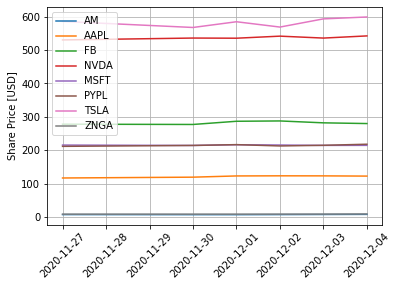

In [10]:
# Plot Open price vs. Time
ax= plt.subplot()
for item in df_price.columns:
    plt.plot(df_price[item])

plt.xticks(rotation=45)
ax.legend(df_price.columns)
plt.ylabel('Share Price [USD]')
ax.grid(True)

## What kind of Growth % do we see with the various listings?

### Normalize the opening price to determine Growth % over the period of interest

Normalize w.r.t. start price (df_start) <br> 
Normalization used: (price-start_price)/start_price*100 to obtain df_norm

In [11]:
# Normalization Function
def df_normalize(df):
    df_strt=df.iloc[0,:]
    df_norm=(df.iloc[:,:]-df_strt)/df_strt*100
    df_strt=pd.DataFrame(df_strt).transpose()
    df_strt.set_axis(['start_price'],axis=0,inplace=True)
    return [df_norm,df_strt]

# Store Normalized values in DataFrame and display results                          
[df_norm,df_start]=df_normalize(df)
df_norm.head()

,AM,AAPL,FB,NVDA,MSFT,PYPL,TSLA,ZNGA
Date,,,,,,,,
2020-11-27,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-11-30,-3.299857,2.109964,-0.302364,1.057592,-0.538953,1.291450,-3.100252,0.243019
2020-12-01,-3.730269,5.257745,3.146032,0.970866,0.455332,2.436252,-0.170718,0.121509
2020-12-02,0.000000,5.566520,3.495192,2.135924,0.065046,0.553478,-2.891970,1.093562
2020-12-03,4.304164,5.446442,1.454234,1.045967,-0.459969,1.490134,1.300873,2.308634


In [12]:
df_start

,AM,AAPL,FB,NVDA,MSFT,PYPL,TSLA,ZNGA
start_price,6.97,116.589996,277.809998,530.293335,215.229996,211.389999,585.76001,8.23


In [13]:
# Size of Data:
print('Size of the data is: {} by {}'.format(df_norm.shape[0],df_norm.shape[1]))

Size of the data is: 6 by 8


In [14]:
# Display basic statistics of the normalized prices
# Darker cells denote higher values
df_norm.describe().loc[['count','mean','min','max'],:].style.background_gradient(axis=1).format("{:.1f}")

,AM,AAPL,FB,NVDA,MSFT,PYPL,TSLA,ZNGA
count,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0
mean,1.0,3.9,1.4,1.2,-0.1,1.5,-0.4,1.7
min,-3.7,0.0,-0.3,0.0,-0.5,0.0,-3.1,0.0
max,8.5,5.6,3.5,2.3,0.5,3.0,2.3,6.7


### Plot trends in Normalized values

Time Plot

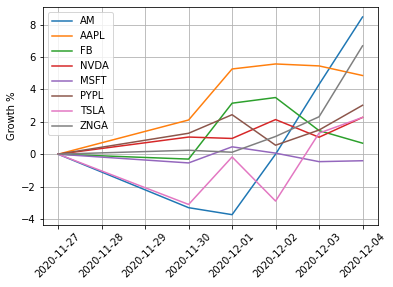

In [15]:
# Display Growth % over time
ax= plt.subplot()
for item in df_norm.columns:
    plt.plot(df_norm[item])

plt.xticks(rotation=45)
ax.legend(df.columns)
plt.ylabel('Growth %')
ax.grid(True)

## How do the price gains of the listings correlate to each other?

Correlation Matrix

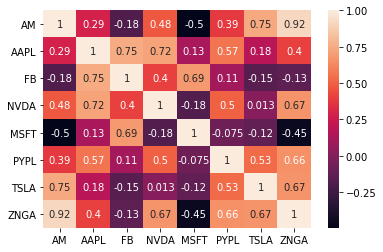

In [16]:
sns.heatmap(df_norm.corr(),annot=True);

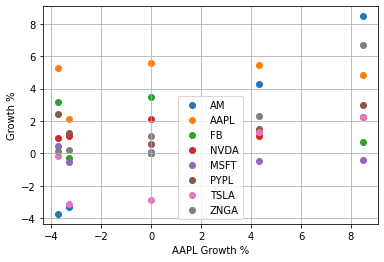

In [17]:
ax= plt.subplot()
for item in df_norm.columns:
    plt.scatter(df_norm.iloc[:,0],df_norm[item])

ax.legend(df_norm.columns)
plt.xlabel('AAPL Growth %')
plt.ylabel('Growth %')
ax.grid(True)

## Calculate percent and absolute estimate and bounds of Growth 

### Create a linear regression fit for the data with thrice the standard dev. of obs.-est. to determine the boundaries

<b> Linear Regression object, score and price boundaries for each listing </b>

In [18]:
def lin_obj(df):
    df_lin=df.iloc[0:1,:]
    df_lin.reindex(['fit_obj','score','bound'])
    df_lin.drop(index=df_lin.index[0],inplace=True)
    for item in df_lin.columns:
        # Implement train-test split thrice and fit the data to the average fit ...
        # ... (intercept and coeff.) of the three splits
        X=np.array(pd.to_numeric(df.index)).reshape(-1, 1)
        Y=(df[item].values).reshape(-1, 1)
        lin_list_coeff=[]
        lin_list_intercept=[]
        for i in range(0,1):
            X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0)
            lin_obj=LinearRegression()
            lin_obj.fit(X_train,y_train)
            lin_list_coeff.append(lin_obj.coef_)
            lin_list_intercept.append(lin_obj.intercept_)
        linobj = LinearRegression()
        linobj.coef_=np.array(np.array(lin_list_coeff).mean()).reshape(-1)
        linobj.intercept_=np.array(np.array(lin_list_intercept).mean()).reshape(-1)
        score=linobj.score(X,Y)
        df_lin.loc['fit_obj',item]=linobj
        df_lin.loc['score',item]=score

    # Calculate price bounds
    df_est=pd.DataFrame()
    df_est.rename_axis(index='Datetime')
    df_est['Datetime']=df.index
    df_est.set_index('Datetime',inplace=True)
    for item in df.columns:
        fit_obj=df_lin.loc['fit_obj',item]
        for datetime in df_est.index:
            est=fit_obj.predict(np.array(datetime.value).reshape(-1,1))
            df_est.loc[datetime,'{}'.format(item)]=est
    for item in df.columns:
        df_diff=df[item]-df_est[item]
        bounds=3*df_diff.std()
        df_lin.loc['bound',item]=bounds
        
    return df_lin

Convert rise and fall from % to price (using price change= percent change/100*start price) and display.<br>

In [19]:
# Call lin_obj(...) to create the price estimation object dataframe
df_price_est_obj=lin_obj(df_norm)
df_price_bounds_dict={}
for item in df_norm.columns:
    df_price_bounds_dict[item]=df_price_est_obj.loc['bound',item]*df_start.loc['start_price',item]/100
df_price_bounds=pd.DataFrame(df_price_bounds_dict,index=['price_bounds'])
df_price_est_obj=df_price_est_obj.append(df_price_bounds)
df_price_est_obj

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/pandas/core/frame.py:4170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,AM,AAPL,FB,NVDA,MSFT,PYPL,TSLA,ZNGA
fit_obj,"LinearRegression(copy_X=True, fit_intercept=Tr...","LinearRegression(copy_X=True, fit_intercept=Tr...","LinearRegression(copy_X=True, fit_intercept=Tr...","LinearRegression(copy_X=True, fit_intercept=Tr...","LinearRegression(copy_X=True, fit_intercept=Tr...","LinearRegression(copy_X=True, fit_intercept=Tr...","LinearRegression(copy_X=True, fit_intercept=Tr...","LinearRegression(copy_X=True, fit_intercept=Tr..."
score,0.391298,0.772271,0.136139,0.697957,0.0828457,0.492668,0.137968,0.554492
bound,10.953,3.28547,4.46419,1.38807,1.11058,2.4106,6.06598,5.14901
price_bounds,0.763427,3.83053,12.402,7.36083,2.39031,5.09577,35.5321,0.423764


### Estimate the price and bounds vs. date using the fit object

In [20]:
# Function to estimate the price given the price dataframe, fit objects and datetime query
def price_est(df,df_price_est_obj,df_strt,datetime_query):
    df_price_est=pd.DataFrame()
    df_price_est.rename_axis(index='Datetime')
    df_price_est['Datetime']=pd.to_datetime(datetime_query)
    df_price_est.set_index('Datetime',inplace=True)
    for item in df.columns:
        fit_obj=df_price_est_obj.loc['fit_obj',item]
        for datetime in df_price_est.index:
            norm_price_est=fit_obj.predict(np.array(datetime.value).reshape(-1,1))
            price_est=norm_price_est*df_strt.loc['start_price',item]/100+df_strt.loc['start_price',item]
            df_price_est.loc[datetime,'{}'.format(item)]=price_est
            df_price_est.loc[datetime,'{}_low'.format(item)]=price_est-(df_price_est_obj.loc['price_bounds',item])
            df_price_est.loc[datetime,'{}_high'.format(item)]=price_est+(df_price_est_obj.loc['price_bounds',item])
            df_price_est.loc[datetime,'{}_lo_mid'.format(item)]=df_price_est.loc[datetime,['{}'.format(item),
                                                                                         '{}_low'.format(item)]].mean()
            df_price_est.loc[datetime,'{}_hi_mid'.format(item)]=df_price_est.loc[datetime,['{}'.format(item),
                                                                                         '{}_high'.format(item)]].mean()
    df_price_est.reindex(df_price_est.index.date)
    df_price_est=df_price_est
    return df_price_est


## What is the predicted share price?

In [21]:
df_price_est=price_est(df,df_price_est_obj,df_start,datetime_query)
df_price_est.head().style.background_gradient(axis=1).format("{:.0f}")

,AM,AM_low,AM_high,AM_lo_mid,AM_hi_mid,AAPL,AAPL_low,AAPL_high,AAPL_lo_mid,AAPL_hi_mid,FB,FB_low,FB_high,FB_lo_mid,FB_hi_mid,NVDA,NVDA_low,NVDA_high,NVDA_lo_mid,NVDA_hi_mid,MSFT,MSFT_low,MSFT_high,MSFT_lo_mid,MSFT_hi_mid,PYPL,PYPL_low,PYPL_high,PYPL_lo_mid,PYPL_hi_mid,TSLA,TSLA_low,TSLA_high,TSLA_lo_mid,TSLA_hi_mid,ZNGA,ZNGA_low,ZNGA_high,ZNGA_lo_mid,ZNGA_hi_mid
Datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-12-28 00:00:00,9,8,10,9,10,147,143,150,145,148,299,287,312,293,306,577,570,585,574,581,212,210,215,211,214,233,227,238,230,235,634,599,670,617,652,10,10,10,10,10


## What kind of volatility do the listings have?

## How do we generate our investment portfolio?

### Estimate the price history along with the bounds and plot the history and estimates for each listing

In [22]:
# Datetime history query values
datetime_query_start_end=pd.date_range(start=start,end=end)

In [23]:
# Generate and display estimates (listing, listing_low, listing_high)
df_price_est_start_end=price_est(df,df_price_est_obj,df_start,datetime_query_start_end)
df_price_est_start_end.head().style.format("{:.0f}")

,AM,AM_low,AM_high,AM_lo_mid,AM_hi_mid,AAPL,AAPL_low,AAPL_high,AAPL_lo_mid,AAPL_hi_mid,FB,FB_low,FB_high,FB_lo_mid,FB_hi_mid,NVDA,NVDA_low,NVDA_high,NVDA_lo_mid,NVDA_hi_mid,MSFT,MSFT_low,MSFT_high,MSFT_lo_mid,MSFT_hi_mid,PYPL,PYPL_low,PYPL_high,PYPL_lo_mid,PYPL_hi_mid,TSLA,TSLA_low,TSLA_high,TSLA_lo_mid,TSLA_hi_mid,ZNGA,ZNGA_low,ZNGA_high,ZNGA_lo_mid,ZNGA_hi_mid
Datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-11-27 00:00:00,7,6,7,6,7,117,113,121,115,119,279,267,291,273,285,531,523,538,527,534,215,213,218,214,217,212,207,217,209,214,575,540,611,558,593,8,8,9,8,8
2020-11-28 00:00:00,7,6,8,6,7,118,114,122,116,120,280,267,292,273,286,532,525,540,528,536,215,213,218,214,216,212,207,217,210,215,577,542,613,559,595,8,8,9,8,8
2020-11-29 00:00:00,7,6,8,6,7,119,115,123,117,121,280,268,293,274,287,534,526,541,530,537,215,213,218,214,216,213,208,218,210,216,579,544,615,561,597,8,8,9,8,8
2020-11-30 00:00:00,7,6,8,7,7,120,116,124,118,122,281,269,293,275,287,535,528,543,531,539,215,213,217,214,216,214,209,219,211,216,581,545,617,563,599,8,8,9,8,9
2020-12-01 00:00:00,7,6,8,7,7,121,117,125,119,123,282,269,294,275,288,537,529,544,533,540,215,213,217,214,216,214,209,219,212,217,583,547,618,565,601,8,8,9,8,9


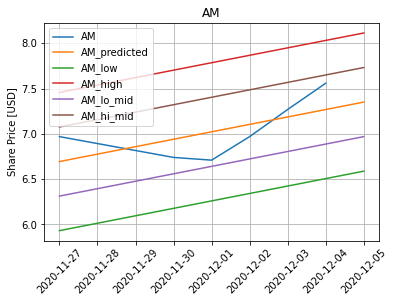

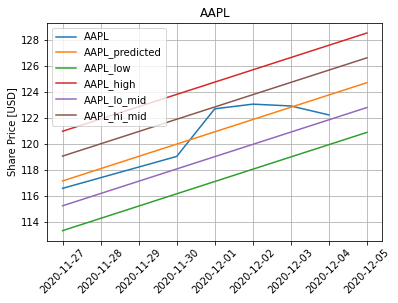

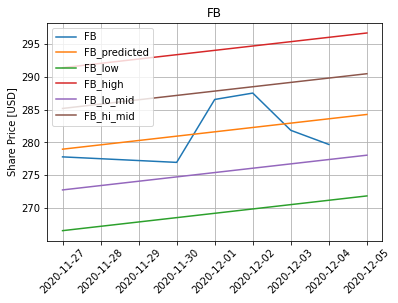

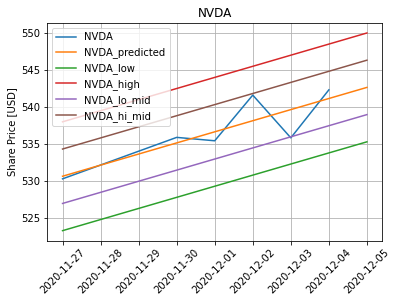

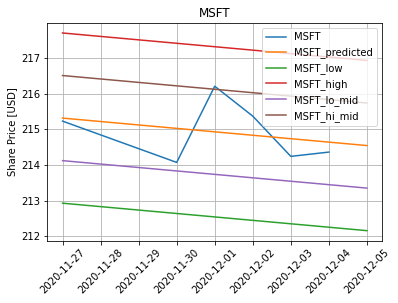

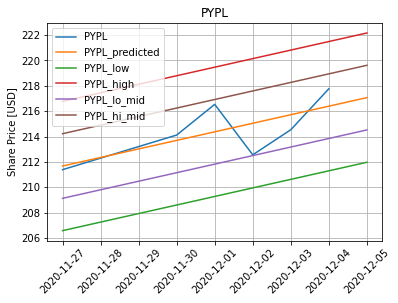

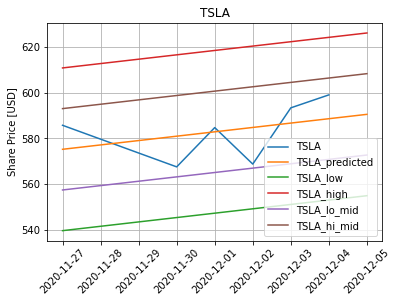

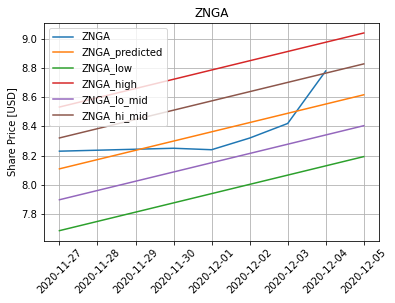

In [24]:
# Plot Open price vs. Time
num_plot=len(df.columns)
i=1
for item in df.columns:
    plt.figure()
    plt.plot(df_price[item])
    plt.plot(df_price_est_start_end[[item,item+'_low',item+'_high',item+'_lo_mid',item+'_hi_mid']])
    plt.legend([item,item+'_predicted',item+'_low',item+'_high',item+'_lo_mid',item+'_hi_mid'])
    plt.ylabel('Share Price [USD]')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.title(item)
    i=i+1

## Constructing the Portfolio

In order to balance the investments, we'd want to have the most benefit (reward) while minimizing volatility (risk).<br>
1. We can consider 'reward' to be the slope of the linear fit to share price (higher the slope, higher the gain).<br>
2. We can consider 'risk' to be the ratio between the price bounds and change in price over the duration of interest <br>
3. Hence we can compute a 'returns ratio' = 'reward'/'risk' for each listing; the higher this value, the more this investment is viable. <br>
4. Then we can compute the sum of the returns ratios for each listing and divide the returns ratio by the summed value, to determine the "weight" of each investment <br>
5. Finally we can multiply the "weight" by the total investment capital (total_investment) to obtain the recommended investment for each listing <br>    

### Use the Linear Regression object to construct the reward, volatility, returns ratio, weight and suggested investment values

In [25]:
# Initialize the portfolio dataframe df_portfolio and update the index suitably
df_portfolio=df_price_est_obj
df_portfolio=df_portfolio.reindex(['reward','risk','returns_ratio','weight','suggested_investment'])
df_portfolio=df_portfolio.rename_axis(index='Parameters')

# Update "reward" using the slope of the line fit (multiplied by a suitable factor for display)
for item in (df_portfolio.columns):
    df_portfolio.loc['reward',item]=(df_price_est_obj.loc['fit_obj',item].coef_[0])*10**17
    
# Update the "volatility" as the percent price bound
for item in (df_portfolio.columns):
    df_portfolio.loc['risk',item]=(df_price_est_obj.loc['bound',item])
                                         
# Update the returns ratio as the ratio between the "reward" and "volatility"
for item in (df_portfolio.columns):
    df_portfolio.loc['returns_ratio',item]=(df_portfolio.loc['reward',item]/
                                            df_portfolio.loc['risk',item])
    
# Remove those listings with negative returns_ratio since those imply a falling stock
for item in df_portfolio.columns:
    if df_portfolio.loc['reward',item]<=0:
        df_portfolio.pop(item)
        
# Obtain the weighted average of the returns ratio for each listing
for item in (df_portfolio.columns):
    df_portfolio.loc['weight',item]=df_portfolio.loc['returns_ratio',item]/df_portfolio.loc['returns_ratio',:].sum()

# Multiply the weight of each listing by the total investment capital to obtain the recommended investment
for item in (df_portfolio.columns):
    df_portfolio.loc['suggested_investment',item]=df_portfolio.loc['weight',item]*total_investment

# Display the portfolio dataframe
df_portfolio.style.background_gradient(axis=1).format("{:.2f}")

,AM,AAPL,FB,NVDA,PYPL,TSLA,ZNGA
Parameters,,,,,,,
reward,1364.35,939.97,275.33,327.82,369.06,377.02,892.45
risk,10.95,3.29,4.46,1.39,2.41,6.07,5.15
returns_ratio,124.56,286.10,61.68,236.17,153.10,62.15,173.32
weight,0.11,0.26,0.06,0.22,0.14,0.06,0.16
suggested_investment,794.90,1825.73,393.58,1507.10,977.00,396.63,1106.06


In [26]:
df_portfolio.to_csv('portfolio.csv')

### What kind of volatility do the listings have?

 Refer the "volatility" row, higher the value, greater the volatility

### How do we use the data to construct our portfolio?

Refer the dataframe "df_portfolio"